In [1]:
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
import seaborn as sns

In [5]:
h5ad_file = 'zenodo/SS3xpress_PBMC_donor4_and_donor7.h5ad'

In [6]:
adata = sc.read_h5ad(h5ad_file)

In [7]:
adata.obs.groupby('orig.ident').count()

,nCount_RNA,nFeature_RNA,percent.mt,integrated_snn_res.0.8,seurat_clusters,cell_annotation
orig.ident,,,,,,
donor4,3820,3820,3820,3820,3820,3820
donor7,3017,3017,3017,3017,3017,3017


In [9]:
XCI_file_donor7 = 'data/PBMC_donor7/vireo_out/donor_ids.tsv'

XCI_file_donor4 = 'data/PBMC_donor4/vireo_out/donor_ids.tsv'

XCI_donor7_df = pd.read_csv(XCI_file_donor7, sep='\t', index_col=0)

XCI_donor4_df = pd.read_csv(XCI_file_donor4, sep='\t', index_col=0)

In [10]:
XCI_donor7_df.index = [cell+'_6' for cell in XCI_donor7_df.index]
XCI_donor4_df.index = [cell+'_4' for cell in XCI_donor4_df.index]

In [12]:
XCI_both_df = XCI_donor4_df.append(XCI_donor7_df)

In [13]:
adata.obs = adata.obs.join(XCI_both_df['donor_id'])

In [14]:
XCI_count_per_donor = adata.obs.groupby('orig.ident').apply(lambda df: df.groupby('donor_id').count())['cell_annotation'].reset_index()

In [15]:
XCI_count_per_donor.columns = ['Donor', 'XCI', 'Count']

In [16]:
XCI_count_per_donor.groupby('Donor').sum()

,Count
Donor,
donor4,3820
donor7,3017


In [18]:
XCI_count_per_cell_type = adata.obs.groupby('orig.ident').apply(lambda df: df.groupby('donor_id').apply(lambda df2: df2.groupby('cell_annotation').count()))[['seurat_clusters']].reset_index()

In [21]:
adata_donor7 = adata[adata.obs['orig.ident'] == 'donor7']

In [22]:
adata_donor7.obs_names = [cell.split('_')[0] for cell in adata_donor7.obs_names]

/home/nbserver/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:873: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "obs")


In [24]:
import cospar as cs

In [26]:
mutation_call_df = pd.read_csv('data/PBMC_donor7/Donor7_clonal_mt_mutations.csv', index_col=0)

In [25]:
mutation_call_bad_muts_df = pd.read_csv('data/PBMC_donor7/mut_calling_bad_muts_all_under_500.csv', index_col=0)

In [27]:
mutation_call_df = mutation_call_df.reindex(adata_donor7.obs.index).dropna()

In [29]:
mutation_call_bad_muts_df = mutation_call_bad_muts_df.reindex(adata_donor7.obs.index).dropna()

In [32]:
mutation_call_df = mutation_call_df.join(mutation_call_bad_muts_df)

In [86]:
(mutation_call_df.sum() > 1).sum()

334

In [39]:
mutation_call_df = mutation_call_df.fillna(False)

In [33]:
adata_donor7.obs['time_info'] = 'Now'

In [34]:
adata_cospar = cs.pp.initialize_adata_object(
    adata=adata_donor7,
    time_info=adata_donor7.obs['time_info']
)

Time points with clonal info: []


In [40]:
mut_clone_df = pd.DataFrame()
for mut, mut_col in mutation_call_df.iteritems():
    bla_df = pd.DataFrame(mut_col.index[mut_col])
    bla_df.columns = ['Cell_ID']
    bla_df['Cell_ID'] = ['_'.join(cell.split('_')[::-1]) for cell in bla_df['Cell_ID']]
    bla_df['Clone_ID'] = mut
    mut_clone_df = mut_clone_df.append(bla_df)

In [47]:
cs.pp.get_X_clone(adata_cospar, mut_clone_df["Cell_ID"], mut_clone_df["Clone_ID"])

100%|██████████| 1848/1848 [00:00<00:00, 13528.83it/s]


In [48]:
adata_cospar.obs['state_info'] = adata_cospar.obs['cell_annotation']

In [49]:
mut_count_series = mut_clone_df.groupby('Cell_ID').count()['Clone_ID']
mut_count_series.name = 'Mutation Count'

In [53]:
adata_cospar.obs = adata_cospar.obs.drop('Mutation Count',axis=1)

In [54]:
adata_cospar.obs = adata_cospar.obs.join(mut_count_series)

In [55]:
import numpy as np

In [56]:
adata_cospar.obs['Mutation Count'] = adata_cospar.obs.apply(lambda row: 0 if np.isnan(row['Mutation Count']) else row['Mutation Count'], axis=1)

adata_cospar.obs['Any Mutation'] = adata_cospar.obs['Mutation Count'] > 0

adata_cospar.obs['Any Mutation Color'] = adata_cospar.obs.apply(lambda row: 'Mutation present' if row['Any Mutation'] else np.nan, axis=1)

In [ ]:
import scanpy as sc

In [92]:
adata_cospar.obs['state_info'] = adata_cospar.obs['cell_annotation']

In [93]:
cs.tl.fate_coupling(
    adata_cospar, selected_fates=['gdT_2',
 'Naive CD4+ T',
 'Naive/CM CD4+ T_1',
 'Clonal CD4+ T',
 'CD4+ TCM/TEM',
 'Naive/CM CD4+ T_2',
 'gdT_1',
 'CD8+ TEM/CD4+ CTL',
 'Tregs',
 'Naive CD8+ T',
 'Naive/CM CD4/CD8+ T',
 'Clonal CD8+ T',
 'CD8+ TCM/TEM'], source="X_clone")  # compute the fate coupling

Results saved as dictionary at adata.uns['fate_coupling_X_clone']


In [94]:
fate_to_idx = {k:i for i, k in enumerate(adata_cospar.uns['fate_coupling_X_clone']['fate_names'])}

In [97]:
order = ['Clonal CD4+ T','Naive/CM CD4+ T_1','Clonal CD8+ T','Tregs','Naive CD4+ T', 'CD4+ TCM/TEM',
 'CD8+ TEM/CD4+ CTL','Naive/CM CD4+ T_2','CD8+ TCM/TEM','Naive CD8+ T',  'Naive/CM CD4/CD8+ T','gdT_1', 'gdT_2'
        ]
order_idx = [fate_to_idx[o] for o in order]

In [87]:
def heatmap(
    data_matrix,
    order_map_x=True,
    order_map_y=True,
    specific_order = [],
    x_ticks=None,
    y_ticks=None,
    col_range=[0, 99],
    color_bar_label="",
    log_transform=False,
    color_map=plt.cm.Reds,
    vmin=None,
    vmax=None,
    fig_width=4,
    fig_height=6,
    color_bar=True,
    x_label=None,
    y_label=None,
    print_ordered_labels=False,
    pseudo_count=10 ** (-10),
    ax=None,
):
    """
    Plot ordered heat map of non-square data_matrix matrix
    Parameters
    ----------
    data_matrix: `np.array`
        The data matrix to be plotted
    order_map_x: `bool`
        Whether to re-order the x coordinate of the matrix or not
    order_map_y: `bool`
        Whether to re-order the y coordinate of the matrix or not
    x_ticks, y_ticks: `list`
        List of variable names for x and y ticks
    color_bar_label: `str`, optional (default: 'cov')
        Color bar label
    data_des: `str`, optional (default: '')
        String to distinguish different saved objects.
    log_transform: `bool`, optional (default: False)
        If true, perform a log transform. This is needed when the data
        matrix has entries varying by several order of magnitude.
    col_range: `tuple`, optional (default: None)
        The default setting is to plot the actual value of the vector.
        If col_range is set within [0,100], it will plot the percentile of the values,
        and the color_bar will show range [0,1]. This re-scaling is useful for
        visualizing gene expression.
    Returns
    ax,
    order_x,
        An integer index for ordered x axis
    order_y,
        An integer index for ordered y axis
    """

    from matplotlib.colors import Normalize as mpl_Normalize

    x_array = np.arange(data_matrix.shape[1])
    y_array = np.arange(data_matrix.shape[0])
    if order_map_x and (data_matrix.shape[1] > 2):
        if data_matrix.shape[0] != data_matrix.shape[1]:
            X = tl.get_normalized_covariance(data_matrix + pseudo_count, method="SW")
            Z = hierarchy.ward(X)
            order_x = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X))
        else:
            Z = hierarchy.ward(data_matrix + pseudo_count)
            order_x = hierarchy.leaves_list(
                hierarchy.optimal_leaf_ordering(Z, data_matrix + pseudo_count)
            )
    elif len(specific_order) > 0:
        order_x = specific_order
    else:
        order_x = x_array

    if order_map_y and (data_matrix.shape[0] > 2):
        if data_matrix.shape[0] != data_matrix.shape[1]:
            order_y = hf.get_hierch_order(data_matrix + pseudo_count)
        else:
            Z = hierarchy.ward(data_matrix + pseudo_count)
            order_y = hierarchy.leaves_list(
                hierarchy.optimal_leaf_ordering(Z, data_matrix + pseudo_count)
            )
    elif len(specific_order) > 0:
        order_y = specific_order
    else:
        order_y = y_array

    if log_transform:
        new_data = np.log(data_matrix[order_y][:, order_x] + 1) / np.log(10)
        label_ = " (log10)"
    else:
        new_data = data_matrix[order_y][:, order_x]
        label_ = ""

    col_data = new_data.flatten()
    if vmin is None:
        if col_range is None:
            vmin = np.min(col_data)
        else:
            vmin = np.percentile(col_data, col_range[0])

    if vmax is None:
        if col_range is None:
            vmax = np.max(col_data)
        else:
            vmax = np.percentile(col_data, col_range[1])
            if (vmax == 0) & (np.max(col_data) >= 1):
                vmax = 1
            if (vmax == 0) & (np.max(col_data) <= 1):
                vmax = np.max(col_data)

    if ax is None:
        fig, ax = plt.subplots()
        ax_=None
    else:
        ax_=ax
    ax.imshow(
        new_data,
        aspect="auto",
        cmap=color_map,
        vmin=vmin,
        vmax=vmax,
        interpolation="none",
    )

    if x_ticks is None:
        plt.xticks([])
    else:
        plt.xticks(
            x_array,
            np.array(x_ticks)[order_x],
            rotation=90,
        )

        if print_ordered_labels:
            x_ticks_print = "','".join(np.array(x_ticks)[order_x])
            print(f"x_order: [{','.join(np.array(order_x).astype(str))}]")
            print(f"x_ticks: ['{x_ticks_print}']")

    if y_ticks is None:
        plt.yticks([])
    else:
        plt.yticks(
            y_array,
            np.array(y_ticks)[order_y],
        )

        if print_ordered_labels:
            y_ticks_print = "','".join(np.array(y_ticks)[order_y])
            print(f"y_order: [{','.join(np.array(order_y).astype(str))}]")
            print(f"y_ticks: ['{y_ticks_print}']")

    if x_label is not None:
        ax.set_xlabel(x_label)

    if y_label is not None:
        ax.set_ylabel(y_label)

    if color_bar:
        norm = mpl_Normalize(vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=color_map))
        cbar.set_label(f"{color_bar_label}{label_}", rotation=270, labelpad=20)
    if ax_ is None:
        plt.gcf().set_size_inches((fig_width, fig_height))
    return ax

def darken_cmap(cmap, scale_factor):
    """
    Generate a gradient color map for plotting.
    """

    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii, 0] = curcol[0] * scale_factor
        cdat[ii, 1] = curcol[1] * scale_factor
        cdat[ii, 2] = curcol[2] * scale_factor
        cdat[ii, 3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap
color_map_reds = darken_cmap(plt.cm.Reds, scale_factor=0.9)
color_map_coolwarm = darken_cmap(plt.cm.coolwarm, scale_factor=1)

"""Settings
"""

verbosity = 3
"""Verbosity level (0=errors, 1=warnings, 2=info, 3=hints)
"""

data_path = "data"
"""Directory where adata is stored (default 'data_cospar').
"""

figure_path = "figure"
"""Directory where plots are saved (default 'figure_cospar').
"""

file_format_figs = "pdf"
"""File format for saving figures.
For example 'png', 'pdf' or 'svg'. Many other formats work as well (see
`matplotlib.pyplot.savefig`).
"""

fig_width = 4
fig_height = 3.5
fig_point_size = 2


logfile = ""
"""Name of logfile. By default is set to '' and writes to standard output."""

# --------------------------------------------------------------------------------
# Functions
# --------------------------------------------------------------------------------

import warnings

from cycler import cycler
from matplotlib import cbook, cm, colors, rcParams

# from cospar import help_functions as hf
# from . import help_functions as hf

warnings.filterwarnings("ignore", category=cbook.mplDeprecation)


def set_rcParams_cospar(fontsize=12, color_map=None, frameon=None):
    """Set matplotlib.rcParams to cospar defaults."""
    # check here if you want to customize it: https://matplotlib.org/stable/tutorials/introductory/customizing.html

    # dpi options (mpl default: 100, 100)
    rcParams["figure.dpi"] = 100
    rcParams["savefig.dpi"] = 150

    # figure (mpl default: 0.125, 0.96, 0.15, 0.91)
    rcParams["figure.figsize"] = (6, 4)
    # rcParams["figure.subplot.left"] = 0.18
    # rcParams["figure.subplot.right"] = 0.96
    # rcParams["figure.subplot.bottom"] = 0.15
    # rcParams["figure.subplot.top"] = 0.91

    # lines (defaults:  1.5, 6, 1)
    rcParams["lines.linewidth"] = 1.5  # the line width of the frame
    rcParams["lines.markersize"] = 6
    rcParams["lines.markeredgewidth"] = 1

    # font
    rcParams["font.sans-serif"] = [
        "Arial",
        "Helvetica",
        "DejaVu Sans",
        "Bitstream Vera Sans",
        "sans-serif",
    ]

    fontsize = fontsize
    labelsize = 0.92 * fontsize

    # fonsizes (mpl default: 10, medium, large, medium)
    rcParams["font.size"] = fontsize
    rcParams["legend.fontsize"] = labelsize
    rcParams["axes.titlesize"] = fontsize
    rcParams["axes.labelsize"] = labelsize

    # legend (mpl default: 1, 1, 2, 0.8)
    rcParams["legend.numpoints"] = 1
    rcParams["legend.scatterpoints"] = 1
    rcParams["legend.handlelength"] = 0.5
    rcParams["legend.handletextpad"] = 0.4
    rcParams["pdf.fonttype"] = 42

    # color cycle
    # rcParams["axes.prop_cycle"] = cycler(color=vega_10)

    # axes
    rcParams["axes.linewidth"] = 0.8
    rcParams["axes.edgecolor"] = "black"
    rcParams["axes.facecolor"] = "white"

    # ticks (mpl default: k, k, medium, medium)
    rcParams["xtick.color"] = "k"
    rcParams["ytick.color"] = "k"
    rcParams["xtick.labelsize"] = labelsize
    rcParams["ytick.labelsize"] = labelsize

    # axes grid (mpl default: False, #b0b0b0)
    rcParams["axes.grid"] = False
    rcParams["grid.color"] = ".8"

    # color map
    rcParams["image.cmap"] = "Reds" if color_map is None else color_map

    # spines
    rcParams["axes.spines.right"] = False
    rcParams["axes.spines.top"] = False

    # frame (mpl default: True)
    frameon = False if frameon is None else frameon
    global _frameon
    _frameon = frameon


# def set_up_plotting(fontsize):
#     """
#     Change matplotlib setting for beautiful plots.
#     """

#     plt.rc('font', family='sans-serif')
#     plt.rcParams['font.sans-serif']=['Helvetica']
#     plt.rc('xtick',labelsize=12) #14
#     plt.rc('ytick', labelsize=12) #14
#     #plt.rc('font', weight='bold')
#     plt.rc('font', weight='regular')
#     plt.rcParams.update({'font.size': fontsize}) #16
#     #plt.rcParams['axes.labelweight'] = 'bold'
#     plt.rcParams['axes.labelweight'] = 'regular'
#     #plt.rcParams['pdf.fonttype'] = 42 #make the figure editable, this comes with a heavy cost of file size


def set_figure_params(
    style="cospar",
    dpi=100,
    dpi_save=300,
    frameon=None,
    vector_friendly=True,
    transparent=True,
    fontsize=14,
    figsize=None,
    pointsize=2,
    color_map=None,
    facecolor=None,
    format="pdf",
    ipython_format="png2x",
):
    """Set resolution/size, styling and format of figures.
    Arguments
    ---------
    style : `str` (default: `None`)
        Init default values for ``matplotlib.rcParams`` suited for `cospar`.
        Use `None` for the default matplotlib values.
    dpi : `int` (default: `None`)
        Resolution of rendered figures - affects the size of figures in notebooks.
    dpi_save : `int` (default: `None`)
        Resolution of saved figures. This should typically be higher to achieve
        publication quality.
    frameon : `bool` (default: `None`)
        Add frames and axes labels to scatter plots.
    vector_friendly : `bool` (default: `True`)
        Plot scatter plots using `png` backend even when exporting as `pdf` or `svg`.
    transparent : `bool` (default: `True`)
        Save figures with transparent back ground. Sets
        `rcParams['savefig.transparent']`.
    fontsize : `int` (default: 14)
        Set the fontsize for several `rcParams` entries.
    figsize: `[float, float]` (default: `None`)
        Width and height for default figure size.
    color_map : `str` (default: `None`)
        Convenience method for setting the default color map.
    facecolor : `str` (default: `None`)
        Sets backgrounds `rcParams['figure.facecolor']`
        and `rcParams['axes.facecolor']` to `facecolor`.
    format : {'png', 'pdf', 'svg', etc.} (default: 'pdf')
        This sets the default format for saving figures: `file_format_figs`.
    ipython_format : list of `str` (default: 'png2x')
        Only concerns the notebook/IPython environment; see
        `IPython.core.display.set_matplotlib_formats` for more details.
    """
    try:
        import IPython

        if isinstance(ipython_format, str):
            ipython_format = [ipython_format]
        IPython.display.set_matplotlib_formats(*ipython_format)
    except:
        pass

    global _rcParams_style
    _rcParams_style = style
    global _vector_friendly
    _vector_friendly = vector_friendly
    global file_format_figs
    file_format_figs = format
    if transparent is not None:
        rcParams["savefig.transparent"] = transparent
    if facecolor is not None:
        rcParams["figure.facecolor"] = facecolor
        rcParams["axes.facecolor"] = facecolor
    if style == "cospar":
        set_rcParams_cospar(fontsize=fontsize, color_map=color_map, frameon=frameon)
    # Overwrite style options if given
    if figsize is not None:
        rcParams["figure.figsize"] = figsize
        global fig_width
        global fig_height
        fig_width = figsize[0]
        fig_height = figsize[1]
    if dpi is not None:
        rcParams["figure.dpi"] = dpi
    if dpi_save is not None:
        rcParams["savefig.dpi"] = dpi_save

    global fig_point_size
    fig_point_size = pointsize

    # hf.set_up_folders()


def set_rcParams_defaults():
    """Reset `matplotlib.rcParams` to defaults."""
    from matplotlib import rcParamsDefault

    rcParams.update(rcParamsDefault)


def _set_start_time():
    from time import time

    return time()


_start = _set_start_time()
"""Time when the settings module is first imported."""

_previous_time = _start
"""Variable for timing program parts."""
def parse_output_choices(adata, key_word, where="obs", interrupt=True):
    if where == "obs":
        raw_choices = [xx for xx in adata.obs.keys() if xx.startswith(f"{key_word}")]
    else:
        raw_choices = [xx for xx in adata.uns.keys() if xx.startswith(f"{key_word}")]

    if (interrupt) and (len(raw_choices) == 0):
        raise ValueError(
            f"{key_word} has not been computed yet. Please run the counterpart function at cs.tl.XXX using the appropriate source name."
        )

    available_choices = []
    for xx in raw_choices:
        y = xx.split(f"{key_word}")[1]
        if y.startswith("_"):
            y = y[1:]
        available_choices.append(y)

    return available_choices
def rename_list(old_names, new_names):
    if new_names is None:
        new_names = old_names

    if len(old_names) != len(new_names):
        logg.warn(
            "The new name list does not have the same length as old name list. Rename operation aborted"
        )
        new_names = old_names
    return new_names

from scipy.cluster import hierarchy
import os

def fate_coupling(
    adata,
    source="transition_map",
    color_bar=True,
    rename_fates=None,
    color_map=color_map_reds,
    figure_index="",
    color_bar_label="Fate coupling",
    title=None,
    vmax=None,
    fig_width = 4,
    fig_height = 3.5,
    fig_point_size = 2,
    specific_order = [],
    **kwargs,
):
    """
    Plot fate coupling determined by the transition map.
    The results should be pre-computed from :func:`cospar.tl.fate_coupling`
    Parameters
    ----------
    adata: :class:`~anndata.AnnData` object
        Assume to contain transition maps at adata.uns.
    {source}
    {color_bar}
    {rename_fates}
    {color_map}
    {figure_index}
    Returns
    -------
    ax:
        The axis object of this plot.
    """

    

    data_des = adata.uns["data_des"][-1]

    if color_bar:
        fig_width = fig_width + 0.5

    key_word = f"fate_coupling_{source}"
    available_choices = parse_output_choices(adata, key_word, where="uns")
    X_coupling = adata.uns[key_word]["X_coupling"]
    fate_names = adata.uns[key_word]["fate_names"]
    rename_fates = rename_list(fate_names, rename_fates)

    if "x_ticks" not in kwargs.keys():
        kwargs["x_ticks"] = rename_fates
    if "y_ticks" not in kwargs.keys():
        kwargs["y_ticks"] = rename_fates

    if vmax is None:
        # vmax = (
        #     np.percentile(X_coupling - np.diag(np.diag(X_coupling)), 95)
        #     + np.percentile(X_coupling - np.diag(np.diag(X_coupling)), 98)
        # ) / 2
        vmax = np.max(X_coupling - np.diag(np.diag(X_coupling)))

    ax = heatmap(
        X_coupling,
        order_map_x=False,
        order_map_y=False,
        specific_order=specific_order,
        color_bar_label=color_bar_label,
        color_bar=color_bar,
        fig_width=fig_width,
        fig_height=fig_height,
        color_map=color_map,
        vmax=vmax,
        **kwargs,
    )

    plt.tight_layout()
    if title is None:
        ax.set_title(f"source: {source}")
    else:
        ax.set_title(title)

    if figure_index != "":
        figure_index == f"_{figure_index}"
    plt.savefig(
        os.path.join(
            figure_path,
            f"{data_des}_{key_word}{figure_index}.{file_format_figs}",
        )
    )
    return ax


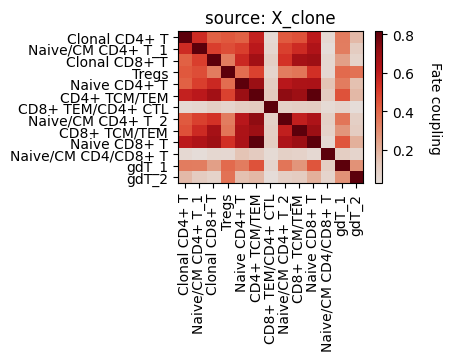

In [99]:
ax = fate_coupling(adata_cospar, source="X_clone", specific_order=order_idx)
plt.savefig('figures/Fig2J.pdf')
plt.show()